### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Navigate to code directory
%cd /content/drive/My Drive/Colab Notebooks/

# List project directory contents
!ls

/content/drive/My Drive/Colab Notebooks
 10_IMAGE_Visualizing-what-convnets-learn.ipynb
 11_IMAGE_GAN_style-transfer.ipynb
 2a_IMAGE_Edge_Detection.ipynb
 3a_3b_IMAGE_FeatureDetection_FeatureMacthing.ipynb
 5a_Face_Detection_Pipeline_HOG_SVM.ipynb
 6_IMAGE_Introduction-to-convnets.ipynb
 7_8_IMAGE_SmallDatabases_Data_Augmentation.ipynb
 9_IMAGE_Pretrained-convnet.ipynb
 _about.txt
 AlejandroGarcia-4b_TEXT_word2vec-songs-recommendation.ipynb
 alex1.jpg
 alex2.jpg
 cats_vs_dogs.h5
'Copia de 10_IMAGE_Visualizing-what-convnets-learn.ipynb'
'Copia de 11_IMAGE_GAN_style-transfer.ipynb'
'Copia de 1a_IMAGE_Basic_Image_Processing.ipynb'
'Copia de 1_IMAGE_how_computers_see_images.ipynb'
'Copia de 2_IMAGE_InsensityColor_Histogram.ipynb'
'Copia de 7_8_IMAGE_SmallDatabases_Data_Augmentation.ipynb'
'Copia de 9b_Fine_tuning_How_to_calculate_DLmodel_parameters.ipynb'
 data
'data (1)'
 elefante.jpg
 hhgroups
 images
 LAB_IMAGE_HandsOnYourOwn_ImageClassifierCNN.ipynb
 leon.jpg
 MachineTranslation_SP_EN_

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [0]:
data = read_text("spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face.', 'Su cara mostraba fatiga.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name.',
        'Pocos estudiantes conocían su nombre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire.', 'Rellena el cuestionario.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [10]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire', 'Rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

Eliminamos la tercera columna ya que no nos interesa para nada

In [0]:
spa_eng = np.delete(spa_eng, 2, axis=1)

In [12]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre'],
       ['Fill out the questionnaire', 'Rellena el cuestionario']],
      dtype='<U278')

In [0]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [14]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['fatigue showed on her face', 'su cara mostraba fatiga'],
       ['few students knew his name',
        'pocos estudiantes conocían su nombre'],
       ['fill out the questionnaire', 'rellena el cuestionario']],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [16]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    4    4
49996    6    6
49997    5    4
49998    5    5
49999    4    3

[50000 rows x 2 columns]
8
12


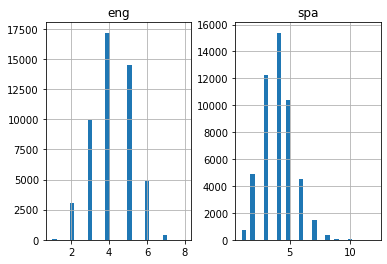

In [17]:
length_df.hist(bins = 30)
plt.show()

La longitud maxima de las frases en español es 10 y la de las frases en ingles es 8

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6917


In [20]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14176


In [0]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 114), ('vete', 30), ('vaya', 39), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 383), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('me', 3073), ('oculté', 1), ('escondí', 3), ('ocultaba', 1), ('escondía', 1), ('corrí', 13), ('corría', 4), ('lo', 2129), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5893), ('tomátelo', 2), ('con', 856), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 505), ('mismo', 129), ('id', 7), ('vayan', 11), ('ya', 338), ('¡lo', 10), ('tengo', 883), ('¿lo', 63), ('pillas', 1), ('¿entendi

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [23]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1    2  969 ...   33    0    0]
 [  11   13  728 ... 2951    0    0]
 [  30  486   14 ...  231    0    0]
 ...
 [  10 3406    7 ...    0    0    0]
 [4520   14   40 ... 1504    0    0]
 [  81  381  250 ...    0    0    0]]
40000
[[   3  487   67 ...    0    0    0]
 [   9  327   43 ...    0    0    0]
 [   1   17   70 ...   50    0    0]
 ...
 [   2  327   13 ...    0    0    0]
 [1224  123  755 ...   25    0    0]
 [   1   50    7 ...    0    0    0]]
40000


In [0]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [24]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[1053   84 1197 ...    0    0    0]
 [  22   78   29 ...    0    0    0]
 [  70   20  832 ...    0    0    0]
 ...
 [1267  141   25 ...    0    0    0]
 [  38  240    6 ...    0    0    0]
 [   3  295  157 ...    0    0    0]]
10000
[[ 81  51  34 ...   0   0   0]
 [  1 108  38 ...   0   0   0]
 [ 71 532   2 ...   0   0   0]
 ...
 [ 11   2  26 ...   0   0   0]
 [  2  17 629 ...   0   0   0]
 [  9   4 224 ...   0   0   0]]
10000


In [0]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [0]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14176
6917
8
8


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [0]:
filename = 'model.h1.5_may_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Let's compare the training loss and the validation loss.

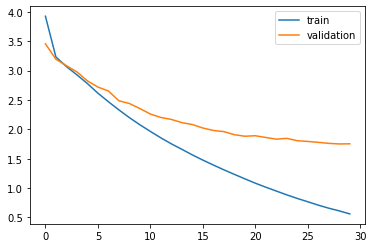

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [0]:
model = load_model('model.h1.5_may_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.head(15)

actual                   predicted
0      so how did this happen         what does  this    
1                  i eat here            i live here     
2              who helped you         who helped tom     
3              smoke appeared      he looked up right    
4    they went to new zealand  they went for a meeting   
5    can you explain it to me  can you explain me to me  
6   four times five is twenty  four plus five is eight   
7    i just wanted to see you  i just wanted to see you  
8           im a little crazy            im a little     
9     im sorry for what i did             im sorry  i    
10              hes too drunk           it too drunk     
11                 tom saw me            tom saw you     
12              tom was dying           tom was worn     
13              this is weird          this is weird     
14           lets hit the hay             lets go to

In [0]:
pred_df.tail(15)

actual                   predicted
9985      you really are nuts     youre sure so wrong    
9986        they kept running     they continued out     
9987    all of these are mine            these   mine    
9988     youve come too early     youve have too  soon   
9989      nobody can stop tom     no cant help anyone    
9990      i dont mind waiting  i wont not care anymore   
9991       happy thanksgiving               many  of     
9992              i loved her            i loved him     
9993  did you come here alone       will you get here    
9994          were surrounded           theyre calm      
9995    i was very busy today    i was very busy today   
9996    i used to be your age    i used to be my friend  
9997       do you like robots      do you like robots    
9998  you have until midnight      it has up midnight    
9999     he is hard to please             it is to  be

In [0]:
pred_df.sample(15)

actual                    predicted
3771   i think tom hates my dog     i think tom dog my dog  
3034    she is a stranger to me        she is a for me him  
1579    theres a lot of traffic            theres a lot     
6346     tom became very famous        tom became a very    
5248       your answer is wrong      this answer is ours    
9978      we dont like violence            we dont like     
3276           come on touch it                were on      
2834      why dont you be quiet         why dont you run    
9424                    you won               you lost      
4824     your jokes arent funny       your arent are not    
6047          tom never arrived          tom never gets     
827         she is fond of cake  she met traveling trips    
8738  i knew tom would ask that      i knew tom would tom   
5365                 tom yelled            tom shouted      
7017       that bicycle is mine     that bicycle is mine

Definimos un nuevo modelo con otros modelos de redes neuronales, en este caso vamos a utilizar simpleRNN en vez de LSTM para observar las diferencias

In [0]:
# build RNN model
def build_model_RNN(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
model = build_model_RNN(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [0]:
filename = 'model.h1.5_may_20_SRNN'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 78s 2ms/step - loss: 6.8957 - val_loss: 5.5131

Epoch 00001: val_loss improved from inf to 5.51306, saving model to model.h1.5_may_20_SRNN
Epoch 2/30
32000/32000 [==============================] - 78s 2ms/step - loss: 4.7522 - val_loss: 4.1638

Epoch 00002: val_loss improved from 5.51306 to 4.16377, saving model to model.h1.5_may_20_SRNN
Epoch 3/30
32000/32000 [==============================] - 78s 2ms/step - loss: 3.9649 - val_loss: 3.9063

Epoch 00003: val_loss improved from 4.16377 to 3.90629, saving model to model.h1.5_may_20_SRNN
Epoch 4/30
32000/32000 [==============================] - 78s 2ms/step - loss: 3.6809 - val_loss: 3.5718

Epoch 00004: val_loss improved from 3.90629 to 3.57175, saving model to model.h1.5_may_20_SRNN
Epoch 5/30
32000/32000 [==============================] - 78s 2ms/step - loss: 3.4396 - val_loss: 3.3956

Epoch 00005: val_loss improved from 3.57175 t

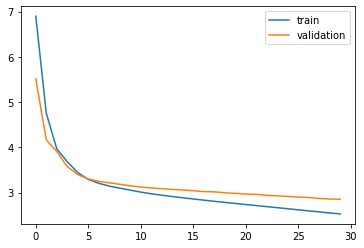

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('model.h1.5_may_20_SRNN')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.head(15)

actual           predicted
0      so how did this happen       i you to     
1                  i eat here      i like it     
2              who helped you            i       
3              smoke appeared       i was me     
4    they went to new zealand       i are to     
5    can you explain it to me        do you      
6   four times five is twenty        the is      
7    i just wanted to see you  i did you to it   
8           im a little crazy        i was a     
9     im sorry for what i did   i dont you  to   
10              hes too drunk       this is      
11                 tom saw me  tom never tom     
12              tom was dying     tom never      
13              this is weird       this is      
14           lets hit the hay          i me

In [0]:
pred_df.tail(15)

actual           predicted
9985      you really are nuts    i are to the    
9986        they kept running         he is      
9987    all of these are mine     youre are      
9988     youve come too early       i have a     
9989      nobody can stop tom          tom       
9990      i dont mind waiting   i dont you it    
9991       happy thanksgiving       are the      
9992              i loved her        i hate      
9993  did you come here alone    do you to me    
9994          were surrounded        youre       
9995    i was very busy today    i was a very    
9996    i used to be your age     i have to a    
9997       do you like robots  do you have me    
9998  you have until midnight      he was to     
9999     he is hard to please      he was to

In [0]:
pred_df.sample(15)

actual          predicted
756            im with a client       he is a     
3003              i love camels        i was      
4244           i wasnt prepared       im not      
2461                be prepared     i was him     
4502     i snapped toms picture  he tom to the    
7556             these are toms      its tom      
2093      it might snow tonight    i dont to a    
1776        get off my property     i was a my    
977             tom left boston      tom is a     
2043       i always believe you    i dont you     
9390  i like to listen to music     i you to a    
2761  tom died monday afternoon      tom is a     
4735         we might get lucky  i dont you to    
3859     itll be a big occasion        i is a     
3736     this food is unhealthy   this is  the

Obsevamos como claramente, en este caso, las predicciones obtenidas por un modelo RNN no son muy buenas, y por tanto, el modelo LSTM inicial parece obtener unos mejores resultados.

Ahora vamos a probar con un modelo GRU, cabe destacar que para la comparación entre modelos, aunque no sea lo más óptimo, se han establecido los mismos valores de los hiperparámetros para poder observar su performance aunque idealmente, habría que optimizar cada modelo de forma individual y finalmente comparar los resultados de forma global.

In [0]:
# build GRU model
def build_model_GRU(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
model = build_model_GRU(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')


filename = 'model.h1.5_may_20_GRU'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 296s 9ms/step - loss: 3.8189 - val_loss: 3.3037

Epoch 00001: val_loss improved from inf to 3.30371, saving model to model.h1.5_may_20_GRU
Epoch 2/30
32000/32000 [==============================] - 299s 9ms/step - loss: 3.1704 - val_loss: 3.1245

Epoch 00002: val_loss improved from 3.30371 to 3.12452, saving model to model.h1.5_may_20_GRU
Epoch 3/30
32000/32000 [==============================] - 295s 9ms/step - loss: 2.9752 - val_loss: 2.9804

Epoch 00003: val_loss improved from 3.12452 to 2.98041, saving model to model.h1.5_may_20_GRU
Epoch 4/30
32000/32000 [==============================] - 297s 9ms/step - loss: 2.8185 - val_loss: 2.8677

Epoch 00004: val_loss improved from 2.98041 to 2.86774, saving model to model.h1.5_may_20_GRU
Epoch 5/30
32000/32000 [==============================] - 296s 9ms/step - loss: 2.6911 - val_loss: 2.7849

Epoch 00005: val_loss improved from 2.86774 

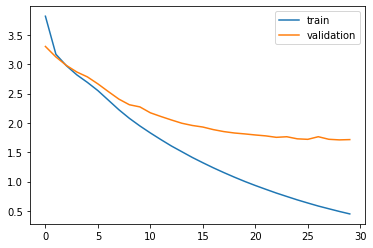

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('model.h1.5_may_20_GRU')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.head(15)

actual                   predicted
0      so how did this happen     how did this  happen   
1                  i eat here             i eat here     
2              who helped you       who betrayed you     
3              smoke appeared     he looked her night    
4    they went to new zealand    they went for chance    
5    can you explain it to me  can you explain it to me  
6   four times five is twenty  four plus five is eight   
7    i just wanted to see you  i just wanted to see you  
8           im a little crazy        im a little busy    
9     im sorry for what i did         im sorry what  i   
10              hes too drunk          shes too very     
11                 tom saw me             tom saw me     
12              tom was dying         tom was crying     
13              this is weird        this is strange     
14           lets hit the hay             lets go to

In [0]:
pred_df.tail(15)

actual                  predicted
9985      you really are nuts       youre sure  than    
9986        they kept running             they ran      
9987    all of these are mine         all these  are    
9988     youve come too early   youve have too early    
9989      nobody can stop tom        no can stop tom    
9990      i dont mind waiting  i wont not wont either   
9991       happy thanksgiving            a  did well    
9992              i loved her              i loved      
9993  did you come here alone     did you come alone    
9994          were surrounded        were babbling      
9995    i was very busy today        i was very busy    
9996    i used to be your age     i used your be your   
9997       do you like robots     do you like robots    
9998  you have until midnight   its has two midnight    
9999     he is hard to please           its a  to you

In [0]:
pred_df.sample(15)

actual                    predicted
7579       theyre normal people       people are normal     
2394       he looked very happy     he looked very happy    
955     tom is clearly worn out  tom is probably getting    
372           why are you angry          why are you mad    
8690     rowing is a lot of fun        this is very much    
9609       the two cars crashed                 we two      
7016         tom almost laughed            tom got gone     
501        trust your intuition         dont touch your     
3506     this food is too salty  this game is very boring   
1315       dont stare at people          dont you the of    
7841   tom ripped up the letter           tom did for on    
879          do you like boston       do you like boston    
4024                  is tom in                 is tom      
8726  i can take care of myself             i know im of    
4623            i saw you on tv   i saw you on television

Parece que este modelo es mejor que el anterior pero aún así parece que el modelo LSTM sigue siendo con el que mejor resultados obtenemos. Esto sucede, como hemos visto en teoria, debdido a que las redes GRU tienen un comportamiento similar a las LSTM pero con menor número de parámetros lo que hace que estas sean más simples y más rápidas de entrenar pero pierden en precisión.

Como podíamos observar en el primer modelo, parece que no llegaba a converger con 30 epochs, vamos a comprobar si esto es así, aumentando el número de epochs hasta 50 para observar las diferencias

In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [0]:
filename = 'model2.h1.5_may_20_LSTM'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [28]:
model = load_model('model2.h1.5_may_20_LSTM')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [32]:
pred_df.head(15)

actual                    predicted
0      so how did this happen       how did you do this   
1                  i eat here           i talked here     
2              who helped you          who helped you     
3              smoke appeared          he kept around     
4    they went to new zealand      they went to a house   
5    can you explain it to me   can you explain it to me  
6   four times five is twenty  four plus five is twenty   
7    i just wanted to see you   i just wanted to see you  
8           im a little crazy          im a little bit    
9     im sorry for what i did            i sorry  i do i  
10              hes too drunk            hes is drunk     
11                 tom saw me              tom saw me     
12              tom was dying          tom was caught     
13              this is weird                this is      
14           lets hit the hay                lets go

In [33]:
pred_df.tail(15)

actual                      predicted
9985      you really are nuts              youre   doing    
9986        they kept running                they left      
9987    all of these are mine                 both are      
9988     youve come too early    youve arrived too early    
9989      nobody can stop tom        nobody one knows us    
9990      i dont mind waiting             i dont mind it    
9991       happy thanksgiving            wait a luck are    
9992              i loved her               i loved him     
9993  did you come here alone         have you come here    
9994          were surrounded            theyre moving      
9995    i was very busy today           i was very  today   
9996    i used to be your age         i used to be the age  
9997       do you like robots         do you like robots    
9998  you have until midnight  she expected ten midnight    
9999     he is hard to please               its is to be

In [34]:
pred_df.sample(15)

actual                  predicted
6609          your job isnt easy        your  isnt easy    
1171      i didnt catch his name  i didnt knew this name   
3200           i need some paper      i need some paper    
9723           love conquers all      love  everything     
6852               are you happy         are you happy     
9681            i love your name       i love your name    
9697       the free ride is over         the moon is in    
6471   dont tell me you stole it        dont tell what     
698        i must help my mother     i must to my mother   
9495      my pen has been stolen       my had my stolen    
5138       tom and i got married     tom and i were with   
2236    we went skiing in canada     i started to lunch    
3050  do you accept credit cards   excuse me a informed    
5011               be supportive                   it      
9414    she had a pleasant dream    she had a very dream

Probablemente conseguiriamos mejorar los resultados obtenidos de accuracy de nuestros modelos aumentando el número de parámetros de la red neuronal, como se ha hecho en otras prácticas tanto de esta asignatura como la de Machine Learning II. Esto lo que hace es ralentizar el proceso de entrenamiento, por ello hay que hacer un balance entre el tiempo de ejecución de los modelos y los valores de precisión que se requieren, en este caso, la precisión no es una prioridad absoluta, por lo que no se han entrenado sucesivos y numerosos modelos para obtener el mejor en accuracy, sino que nos hemos centrado más en el funcionamiento de los diferentes modelos.

Finalmente se puede apreciar, que se podría lograr un mejor traductor con un LSTM ya que trabaja mejor con datasets más grandes y se han obtenido mejores resultados que con un modelo tipo SimpleRNN y que con un GRU, pese a que este último sea similar a los modelos LSTM pero más simple, y con peores resultados.